# HyperSmORF
## Using hyperbolic neural networks to identify small proteins
##

In [17]:
# Import libraries
%load_ext autoreload
import sys
import os
from itertools import combinations, starmap
import pandas as pd
import numpy as np
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
#import tensorflow_io as tfio

import Levenshtein
from multiprocessing import Pool
from functools import partial
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt

import shutil
from model.models_cstm import get_embedding_model
from model.train_model import train_siamese_model
from utils.preprocessing import *
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and process dataset

In [18]:
# Import dataset

df = pd.read_csv("datasets/dataset_FINAL.tsv", sep='\t')
df.head()


,set,clust,name,origin,y,upstream,downstream,smorf
0,train,smorfam02316,SRS015578|100_12635.12635|324|473|1,real,positive,GCAGTGGAAACTGTGGAAGCTGCGGTGGATGCAGCGGTGCTGCTTT...,TGGTAGATATAAT,ATGGGAAATTCAACAGGATCCACAATGTACATGTTTGGTGCGGTCA...
1,train,smorfam00029,SRS017247|9023|255|395|1,real,positive,AANATGACTTTTTTTCTCTTTTGCCTTCATTTTTCTGATATAGAAC...,TTCTGACAGGNTTCGGATAAATCATNTATCTTTGCAAGGATAGTGA...,ATGAAACAGAGAAAAGTTTTAGTAGGTATCGCTATTGCCATTTTCA...
2,train,smorfam02445,SRS049896|22905|185|292|1,real,positive,GCGGAATTTTTTCTTAAAAGGCATTGACAAGGGAAACGATGCGTGA...,TGCTGTTTGGTTTTGCGGGTATTGCCGCCATCGCGGGTCTGATCTT...,ATGAAGATCGTAAAGAAGCTGGTAGCCGCCCTGATGGTGCTGGGCG...
3,train,smorfam00002,SRS015174|51208|59|208|-1,real,positive,ATATTTAGAAGTATGATTATGAAGTGCAAATAACTGCGTCAGGATT...,TAACTGAAGGCCCCCCCCCCTTTTCCGCCCCTTTTTTTTTTTTTTT...,ATGAGCAGAATTAAGACAATTTCAACAAGAAATATGGCAAAGTCAA...
4,train,smorfam01037,SRS063985|100_30365.30365|110|235|-1,real,positive,AAGCAAAACCGGCAGTGGAAGAAAACAAATACATCGCCATTGAAGG...,TTACAATAGACTATTTTAGGAGGAATGACTTATGTTAGTACCAAGT...,ATGTCAGACAAAAATCCAAAACATCCATTAAAAAAGAAGAAAGTAA...


In [19]:
# save subset of dataset

df_subset=df.dropna().sample(100, random_state=42)

if not os.path.exists('processed_data'):
    os.makedirs('processed_data')
    
df_subset.to_csv('processed_data/smorf_subset.csv')
df_subset.head()

,set,clust,name,origin,y,upstream,downstream,smorf
60287,train,smorfam02935,SRS144135|31130|129|275|-1,real,positive,GATTAATAAACAAAAAAGAAATAATTCGTTGACTAAAATGTAAAAA...,AATGATTCTTTCTGTAATAAAAAAGTAAAAATGTAATTAAAAAGTA...,ATGTTAAATGACGAAATATGTAAATTAAGAGATAGATTAAACGAAA...
38271,train,smorfam00398,SRS049896|100_4224.208254|61|198|-1,real,positive,AGGACATTTATCGCTTTCAGACCTATCTGGAAGATCACAGCACCAC...,AAACACCCTGTCGGTGCTGAAAATTGCACCGGGACAGCATCCGCAG...,ATGCTGAACTTTTTTATCGGTATCGCATTTTTTGAGGCTGGTGCCT...
447517,dev,195481,SRS146830|1340|13074|13202|1,fake,negative,CGAATAGAATACAATTTTATTATAATGGTAAAGCTGAAAAGCCGAG...,AATGCCTTTAGACCCCAAGTTTTGTACTGACATGTAGATTTTATTA...,ATGACGCTCTTATTTTTCAATGTCCTCCGTATTGCAAGAATTTATT...
255578,train,smorfam01930,SRS015578|100_386.194237|8|127|-1,fake,negative,AATTTTATTAAATGAATTTGTAAATGTGTTTGTTTTATGTCAAATA...,CTGGATG,ATGGAAATAGAGTTGAATTGTTGGTCCGGTTATAGTTTAAATTTAA...
392941,train,70008,SRS055966|100_160.161|2113|2259|1,fake,negative,TAGGGATCACCTCCGGAGGGCAGGTGCGGCTGGAATCTTCTAGATA...,TAGCACTTATGATCCGATCCAAACAGTGAGAATTCACAAGAAGACT...,GTGGATTCTGCGATGTCGATGGAGAGAGCCGGGTCGCCCGGGGGGA...


In [20]:
# save dataset as fasta

file_out='datasets/dataset_FINAL.fasta'
file_subset_out='datasets/subset_FINAL.fasta'
records = [SeqRecord(Seq(str(seq)), index) for index,seq in zip((df.name.values), (df.smorf.values))]
with open(file_out, 'w') as f_out:
    SeqIO.write(records, f_out, 'fasta')
    

In [21]:
records_subset = [SeqRecord(Seq(str(seq)), index) for index,seq in zip((df_subset.name.values), (df_subset.smorf.values))]
with open(file_subset_out, 'w') as f_out:
    SeqIO.write(records_subset, f_out, 'fasta')

In [22]:
# run basic Neuroseed (Philippe's version) on data

DISTANCE_METRICS = {
    'EUCLIDEAN': 'euclidean',
    'HYPERBOLIC': 'hyperbolic',
    'MANHATTAN': 'manhattan',
    'SQUARE': 'square',
    'COSINE': 'cosine'
}

((X_train, X_test, X_val), (y_train, y_test, y_val))=process_seqs(file_subset_out)

embedding = get_embedding_model(in_dim=153,model_choice='MLP')
embedding.summary()

Reading inputs...
	Done in 0.005 seconds
	Shape of X: (100, 153)
Splitting X values...
	Done in 0.001 seconds
	Shapes of data: (80, 153), (20, 153), (20, 153)
Getting edit distances for y_train...
Finished row 0 of 80.	Time taken:0.003
Finished row 1 of 80.	Time taken:0.002
Finished row 2 of 80.	Time taken:0.003
Finished row 3 of 80.	Time taken:0.003
Finished row 4 of 80.	Time taken:0.002
Finished row 5 of 80.	Time taken:0.002
Finished row 6 of 80.	Time taken:0.002
Finished row 7 of 80.	Time taken:0.002
Finished row 8 of 80.	Time taken:0.002
Finished row 9 of 80.	Time taken:0.002
Finished row 10 of 80.	Time taken:0.002
Finished row 11 of 80.	Time taken:0.002
Finished row 12 of 80.	Time taken:0.002
Finished row 13 of 80.	Time taken:0.002
Finished row 14 of 80.	Time taken:0.002
Finished row 15 of 80.	Time taken:0.002
Finished row 16 of 80.	Time taken:0.002
Finished row 17 of 80.	Time taken:0.002
Finished row 18 of 80.	Time taken:0.002
Finished row 19 of 80.	Time taken:0.002
Finished row 

In [23]:
np.shape(X_train[1])
print(tf.__version__)

2.4.1


In [49]:
# Train and Test Siamese Model
%autoreload 2
data = ((X_train, X_test, X_val), (y_train, y_test, y_val))
dist = DISTANCE_METRICS['HYPERBOLIC']

model, score, history = train_siamese_model(data, embedding, dist , batch_size=1024, epochs=4)

153
Tensor("sub:0", shape=(1024, 128), dtype=float32)
Epoch 1/4
Tensor("sub:0", shape=(1024, 128), dtype=float32)
3/3 [==============================] - 0s 41ms/step - loss: nan
Epoch 2/4
3/3 [==============================] - 0s 42ms/step - loss: nan
Epoch 3/4
3/3 [==============================] - 0s 41ms/step - loss: nan
Epoch 4/4
3/3 [==============================] - 0s 50ms/step - loss: nan
Model: "siamese_model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_27 (Functional)        (None,)                   111490    
Total params: 111,492
Trainable params: 111,490
Non-trainable params: 2
_________________________________________________________________


In [ ]:
print(f'Score for Hyperbolic Model using {dist} distance: {score}')

Score for Hyperbolic Model using hyperbolic distance: 3644.784912109375


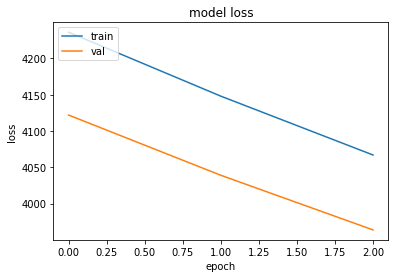

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Build neural nets on keras

#### Binary result

In [ ]:

model = Sequential()
model.add(Dense(12, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x,y, epochs=150, batch_size=10)

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2022-02-28 08:16:35.885886: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-02-28 08:16:35.885927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lambda-quad
2022-02-28 08:16:35.885933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lambda-quad
2022-02-28 08:16:35.886103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-02-28 08:16:35.886126: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.91.3
2022-02-28 08:16:35.886131: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 460.91.3 does not match DSO version 470.103.1 -- cannot find working devices in this configuration
2022-02-28 08:16:35.886543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Te

NameError: name 'x' is not defined